# Stromverbrauchsprognose unter Verwendung von Wetterdaten
In diesem Projekt soll anhand von bereitgestellten Wetter- und vergangener Energieverbrauchsinformationen der zukünftige Energieverbrauch in 1h bzw. 24h prognostiziert werden.  
Die Prognosen sollen mittels verschiedener Modelle erstellt und deren Ergebnisse im Anschluss miteinander verglichen werden.  

## Setup

In [1]:
#
import pandas as pd
import numpy as np

#
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Show mulitple outputs within one kernel-----------------------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline
#pd.set_option('display.float_format', lambda x: '%.3f' % x) #diplay command only show the first 5 digits

# 1. Überblick und  Datenbereinigung 
Wir arbeiten hierfür mit zwei Datensätzen.
* 'SystemLevelSummer.csv' enthält Informationen zum Stromverbrauch, welche im Wesentlichen vorhergesagt werden sollen.
* 'weatherDFLocalSummer.csv' enthält Wetterinformationen 

## 1.1 Laden der Datensätze

In [2]:
powerDF = pd.read_csv('./data/SystemLevelSummer.csv')
weatherDF = pd.read_csv('./data/WeatherLocalSummer.csv')

In [3]:
powerDF.columns
powerDF.head()

Index(['#DATE', ' TOTAL_LOAD'], dtype='object')

,#DATE,TOTAL_LOAD
0,2011-06-01 00:15,639691.499583
1,2011-06-01 00:30,624777.006874
2,2011-06-01 00:45,610658.780201
3,2011-06-01 01:00,597351.542302
4,2011-06-01 01:15,583547.506936


In [4]:
weatherDF.columns
weatherDF.head()

Index(['# DATE', ' TEMPERATURE [F]', ' HUMIDITY [%]', ' PRESSURE [inHg]',
       ' WIND_SPEED [m/s]', ' RAINFALL [mm]'],
      dtype='object')

,# DATE,TEMPERATURE [F],HUMIDITY [%],PRESSURE [inHg],WIND_SPEED [m/s],RAINFALL [mm]
0,2011-05-30 17:00,86.635,51.563,29.941,7.523,0.0
1,2011-05-30 18:00,84.931,56.044,29.945,7.453,0.0
2,2011-05-30 19:00,83.100,61.551,29.952,6.930,0.0
3,2011-05-30 20:00,80.823,69.142,29.967,6.979,0.0
4,2011-05-30 21:00,79.305,75.395,29.983,6.677,0.0


Hierbei ist zu erkennen, dass der Datensatz powerDF die Spalten "Datum" und "Gesamtstromverbrauch" enthält. WeatherDF besitzt die Spalten "Datum", "Temperatur", "Luftfeuchtigkeit", "Druck", "Windgeschwindigkeit" und "Niederschlag".

## 1.2 Überarbeitung der Datenstruktur
Nachfolgend sollen die Datensätze so überarbeitet werden, damit diese im weiteren Verlauf sinnvoll und bequem untersucht werden können.  

### 1.2.1 Allgemeine Änderungen
Zunächst werden in den Spaltennamen nicht notwendige Leerzeichen entfernt, um die Lesbarkeit zu erleichtern.  
Zudem soll die Spalte "#DATE" in ein Datumsformat umgewandelt sowie anschließend als Index des Dataframes festgelegt werden, um Bezug zu einer Zeitskala herzustellen.  
Dabei wird sichergestellt, dass die Daten in aufsteigender Reihenfolge sortiert werden. Für eine bessere Übersicht und zukünftige Modelle werden noch Tag und Monat extrahiert.

In [5]:
def generalModification(df):
    #General Modifications---------------------
    df.columns = df.columns.str.replace(" ", "")

    #Date Modifications------------------------
    df['#DATE'] = pd.to_datetime(df['#DATE'])
    df = df.set_index('#DATE').sort_index()
    df.index = df.index.tz_localize('UTC') #ensure timezone-aware format for further modifications

    #Separate the datetime in separate columns
    df['MONTH'] = df.index.month
    df['DAY'] = df.index.day
    df['HOUR'] = df.index.hour

    return df

In [6]:
powerDF = generalModification(powerDF)
weatherDF = generalModification(weatherDF)

### 1.2.2 Überprüfung auf Datenlücken
Wir wollen NaN Werte in unserem Datensatz ausschließen, da diese das Arbeiten mit den Daten erschweren und beim Auftreten genauer betrachtet werden müssten.  

In [7]:
#detect NaN values in the two df
any(map(lambda df: df.isna().any().any(), [powerDF, weatherDF]))

False

Zudem überprüfen wir gleich, ob wir Lücken innerhalb der Daten haben, also ob wir es mit einer kontinuierlichen Datenerfassung zu tun haben.  
Dazu betrachten wir jeweils die Differenz zweier aufeinanderfolgender Einträge und es soll bestimmt werden, ob diese von der zu erwartetenden Differenz abweicht. Diese leiten wir aus den Tabellen in 1.1 ab.  
  
Dabei erwarten wir folgende Abstände zwischen zwei Einträgen:

* powerDF - 15 min 
* weatherDF - 60 min 
  

In [8]:
#Ensure equal time periods between data
(powerDF.index.diff()[1:] == pd.Timedelta(minutes=15)).all()
(weatherDF.index.diff()[1:] == pd.Timedelta(minutes=60)).all()

True

True

Die Zeitabstände zwischen je zwei Daten sind stets identisch, somit sind die Daten kontinuierlich erfasst worden.

### 1.2.3 Spezielle Überarbeitung powerDF
Da die Zeitabstände in powerDF 15 Minuten betragen und in weatherDF stündlich aufgenommene Messwerte vorliegen, soll im Folgenden der Dataframe powerDF überarbeitet bzw. an den Wetter-Datensatz angepasst werden.  
Weil es in beiden Datensätzen keine Lücken gibt, können in powerDF die einzelnen Werte zu Stundenwerte zusammengefasst werden.
  
Dabei verwerfen wir den ersten und letzen Eintrag, da wir hierfür keine volle Stunde erhalten würden und somit die Puntke nicht mit dem Rest vergleichbar wären.

In [9]:
#Resample the TOTAL_LOAD values to the summed load and keep DAY and MONTH
powerDF = powerDF.resample('h').agg({
    'TOTAL_LOAD': 'sum',
    'MONTH': 'first',
    'DAY': 'first',
    'HOUR' : 'first'
})[1:-1]

<span style="color:red">Die Einträge von powerDF haben aktuell fünf Nachkommastellen. ....</span>

In [10]:
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD']/(1000**2)
powerDF['TOTAL_LOAD'] = powerDF['TOTAL_LOAD'].round(3)

### 1.2.4 Spezielle Überarbeitung weatherDF
Da in Deutschland bei Temperaturmessungen die Einheit Celsius gängiger ist als Fahrenheit, wird im Folgenden die Spalte "TEMPERATURE[F]" umgwandelt. Ebenso wird bar als Einheit für den Druck verwendet.

In [11]:
#Adjust Fahrenheit to Celsius
weatherDF['TEMPERATURE[F]'] = (weatherDF['TEMPERATURE[F]']-32)/1.8
weatherDF = weatherDF.rename(columns={'TEMPERATURE[F]': 'TEMPERATURE[C]'})

#Adjust inHg to bar
weatherDF['PRESSURE[inHg]'] = (weatherDF['PRESSURE[inHg]'])*0.03386
weatherDF = weatherDF.rename(columns={'PRESSURE[inHg]': 'PRESSURE[bar]'})

## 1.3 Überblick über die Daten 
Nun soll sich von den überarbeiteten Datensätzen ein genauerer Überblick verschaffen werden, um sie gegebenenfalls weiter sinnvoll zu bearbeiten bzw. aneinander anzupassen.


In [12]:
powerDF.columns
powerDF

Index(['TOTAL_LOAD', 'MONTH', 'DAY', 'HOUR'], dtype='object')

,TOTAL_LOAD,MONTH,DAY,HOUR
#DATE,,,,
2011-06-01 01:00:00+00:00,2.313,6,1,1
2011-06-01 02:00:00+00:00,2.155,6,1,2
2011-06-01 03:00:00+00:00,2.067,6,1,3
2011-06-01 04:00:00+00:00,2.086,6,1,4
2011-06-01 05:00:00+00:00,2.222,6,1,5
...,...,...,...,...
2011-08-31 19:00:00+00:00,4.691,8,31,19
2011-08-31 20:00:00+00:00,4.468,8,31,20
2011-08-31 21:00:00+00:00,4.089,8,31,21


In [13]:
weatherDF.columns
weatherDF

Index(['TEMPERATURE[C]', 'HUMIDITY[%]', 'PRESSURE[bar]', 'WIND_SPEED[m/s]',
       'RAINFALL[mm]', 'MONTH', 'DAY', 'HOUR'],
      dtype='object')

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-05-30 17:00:00+00:00,30.352778,51.563,1.013802,7.523,0.0,5,30,17
2011-05-30 18:00:00+00:00,29.406111,56.044,1.013938,7.453,0.0,5,30,18
2011-05-30 19:00:00+00:00,28.388889,61.551,1.014175,6.930,0.0,5,30,19
2011-05-30 20:00:00+00:00,27.123889,69.142,1.014683,6.979,0.0,5,30,20
2011-05-30 21:00:00+00:00,26.280556,75.395,1.015224,6.677,0.0,5,30,21
...,...,...,...,...,...,...,...,...
2011-09-01 12:00:00+00:00,31.492222,55.515,1.013938,5.650,0.0,9,1,12
2011-09-01 13:00:00+00:00,32.403889,49.891,1.013193,5.407,0.0,9,1,13
2011-09-01 14:00:00+00:00,33.896667,41.848,1.012245,5.461,0.0,9,1,14


In [14]:
powerDF.describe()
weatherDF.describe()

,TOTAL_LOAD,MONTH,DAY,HOUR
count,2207.000000,2207.000000,2207.000000,2207.000000
mean,3.746179,7.011328,15.843679,11.505211
std,0.969472,0.814287,8.852603,6.920992
min,1.925000,6.000000,1.000000,0.000000
25%,2.855500,6.000000,8.000000,6.000000
50%,3.707000,7.000000,16.000000,12.000000
75%,4.583000,8.000000,23.500000,17.500000
max,5.720000,8.000000,31.000000,23.000000


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,28.996319,64.212354,1.012991,3.917266,0.007017,6.998227,15.930408,11.500000
std,3.580114,18.236110,0.002548,1.932054,0.059717,0.856951,9.026840,6.923721
min,19.231667,21.227000,1.006285,0.000000,-0.180000,5.000000,1.000000,0.000000
25%,26.172083,47.808250,1.011322,2.487000,0.000000,6.000000,8.000000,5.750000
50%,28.267222,66.830500,1.012837,3.733500,0.000000,7.000000,16.000000,11.500000
75%,31.836528,81.200250,1.014412,5.313000,0.000000,8.000000,24.000000,17.250000
max,39.385556,98.210000,1.022470,11.592000,1.800000,9.000000,31.000000,23.000000


Aus dem Datensatz mit dem Stromverbrauch ist bereits zu erkennen, dass die Messwerte im Zeitraum vom 01.06.2011 bis 01.09.2011 im 15-Minutentakt vollständig aufgenommen worden sind, welche vorhin jedoch in Stundenwerte umgwandelt worden sind. Der Datensatz mit den Wetterdaten hingegen bezieht sich auf den Zeitraum 30.05.2011 ab 17:00 Uhr bis 01.09.2011 16:00 Uhr. Somit liegen bei letzterem Datensatz mehr Werte vor als beim ersten, was auch am unterschiedlichen Count-Wert in der Daten-Zusammenfassung zu erkennen ist. In beiden Datensätzen werden jedoch vollständig die drei Sommermonate Juni, Juli und August für das Jahr 2011 betrachtet. In den Wetterdaten sind stündliche Messwerte zu Temperatur (in °C), Luftfeuchtigkeit (in %), Druck (in bar), Windgeschwindigkeit (in m/s) und Niederschlag (in mm) enthalten.

Im Folgenden werden die einzelnen Messwerte in Abhängigkeit von der Zeit geplottet.

In [15]:
def plotDF(df, column, title, y_axis):
    plt.figure(figsize=(20, 4))

    plt.plot(df.index, df[column])

    plt.title(title)
    plt.xlabel('Zeitskala')
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

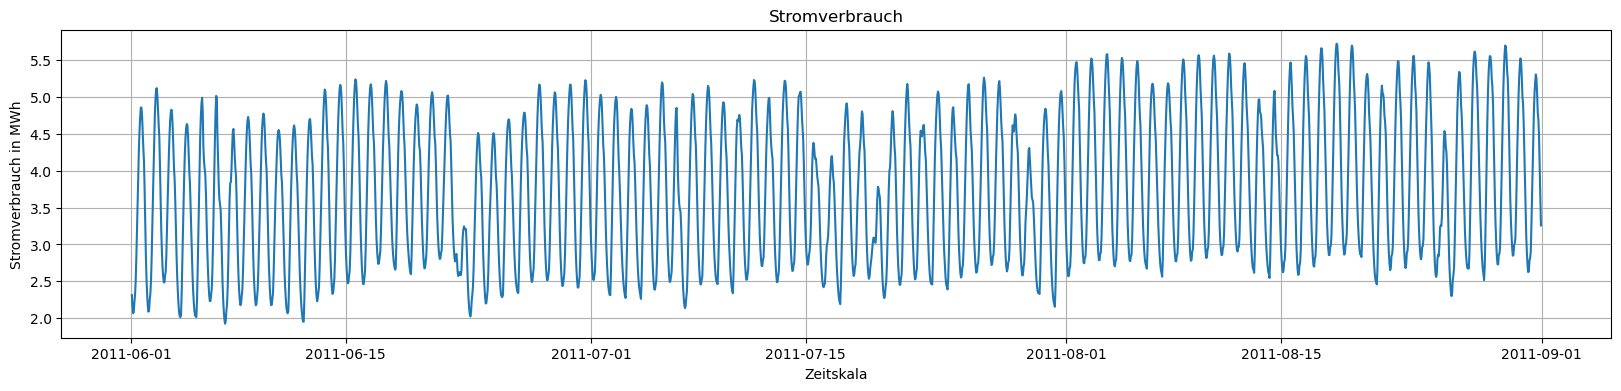

In [16]:
plotDF(powerDF, 'TOTAL_LOAD', 'Stromverbrauch', 'Stromverbrauch in MWh')

Im Plot zum Stromverbrauch wird ersichtlich, dass sich im Zeitraum zwischen 15.06. und 01.07. ein Ausreißer befindet, da der Verbrauch an dieser Stelle für längere Zeit ziemlich gering ist. Zudem ist auch im Zeitraum vom 15.07. bis 01.08. ein Ausreißer zu erkennen.   

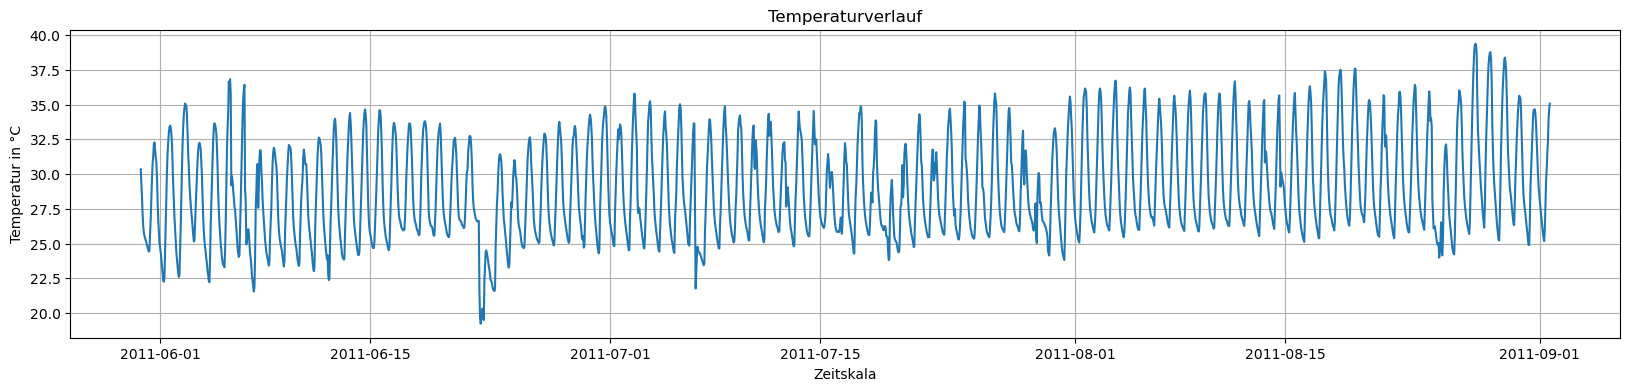

In [17]:
plotDF(weatherDF, 'TEMPERATURE[C]', 'Temperaturverlauf', 'Temperatur in °C')

Beim Temperaturverlauf ist der Ausreißer zwischen 15.06. und 01.07. sehr auffällig, da die Temperatur recht niedrig ist.

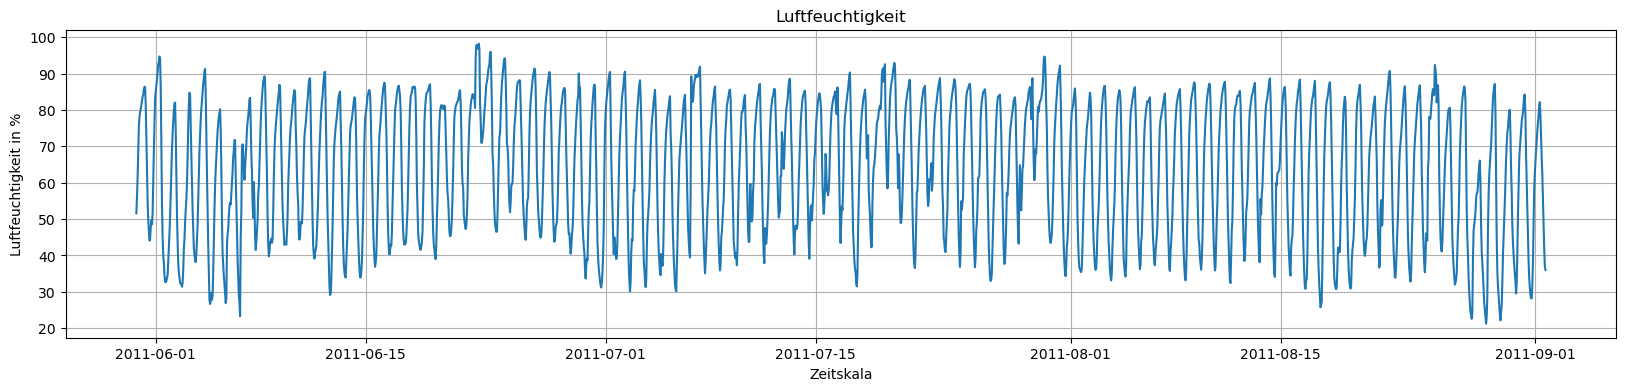

In [18]:
plotDF(weatherDF, 'HUMIDITY[%]', 'Luftfeuchtigkeit', 'Luftfeuchtigkeit in %')

Im Plot zur Luftfeuchtigkeit ist zu erkennen, dass sowohl im Zeitraum vom 15.06. bis 01.07. als auch zwischen 15.07. und 01.08. Ausreißer vorliegen. Die Luftfeuchtigkeit ist in beiden Zeiträumen äußerst hoch.

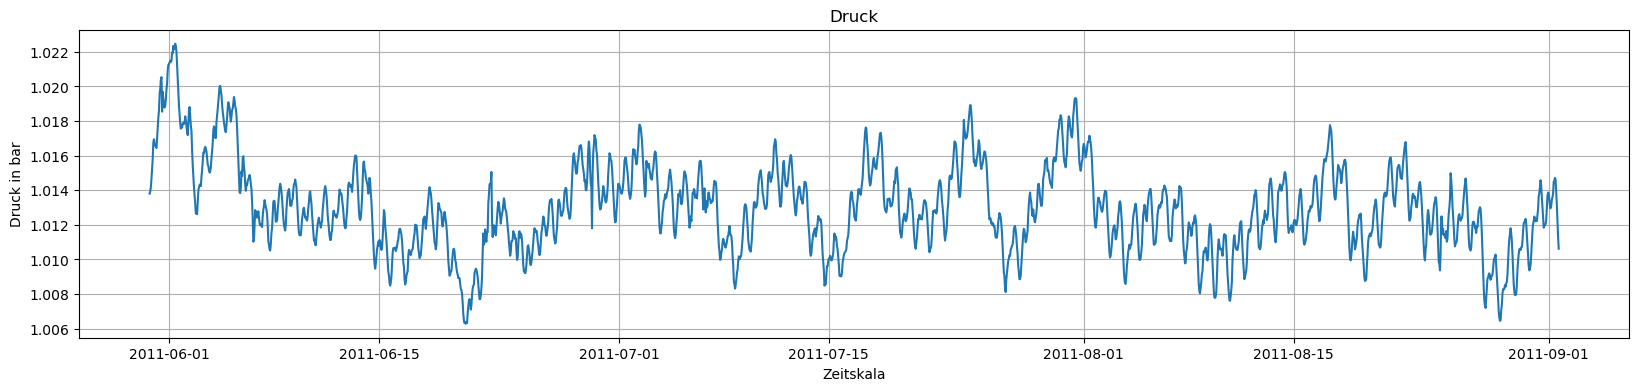

In [19]:
plotDF(weatherDF, 'PRESSURE[bar]', 'Druck', 'Druck in bar')

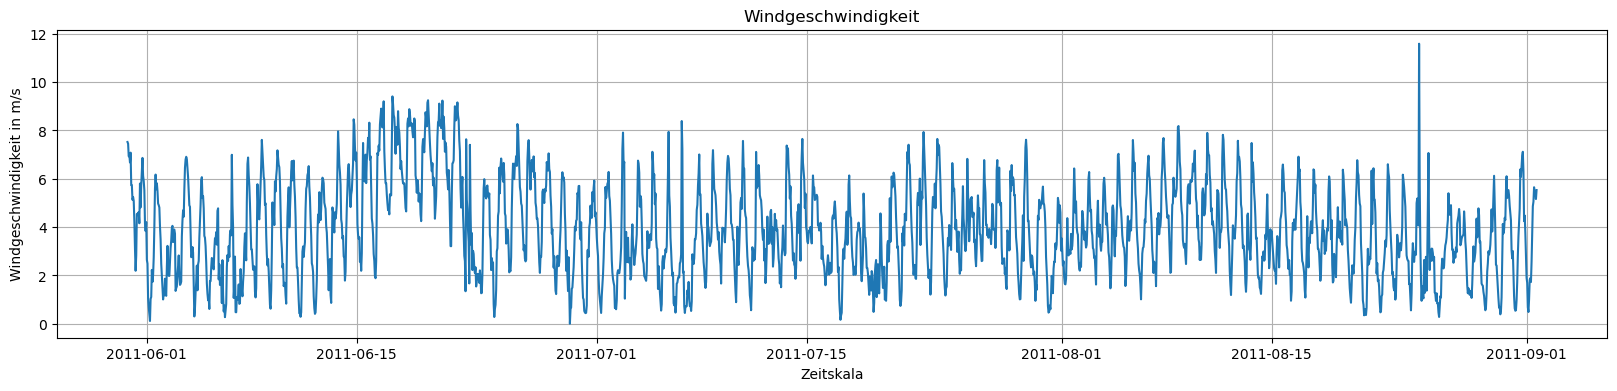

In [20]:
plotDF(weatherDF, 'WIND_SPEED[m/s]', 'Windgeschwindigkeit', 'Windgeschwindigkeit in m/s')

Auch bei der Windgeschwindigkeit ist ein Ausreißer zwischen 15.08. und 01.09. ersichtlich, der im Vergleich zu den restlichen Werten sehr hoch ist mit einer Geschwindigkeit von gerundet 11,59 m/s. Zudem herrschte im Zeitraum vom 15.06. und 01.07. für mehrere Tage eine erhöhte Windgeschwindigkeit. 

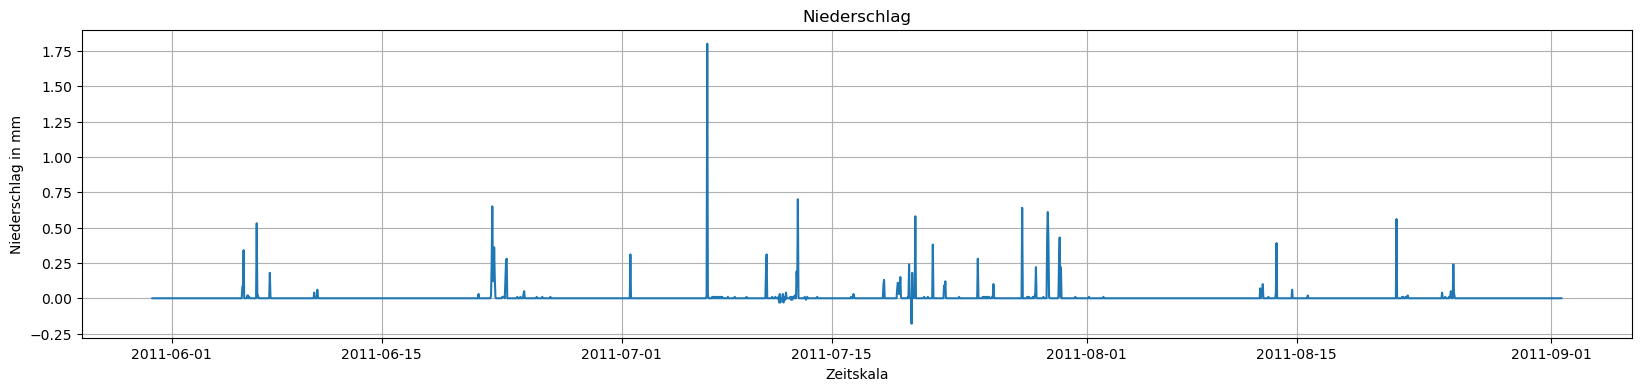

In [21]:
plotDF(weatherDF, 'RAINFALL[mm]', 'Niederschlag', 'Niederschlag in mm')

Sowohl in der Daten-Zusammenfassung als auch im Plot zum Niederschlag ist zu erkennen, dass es negative Messwerte gibt, was logischerweise nicht möglich ist und vermutlich Folge einer fehlerbehafteten Messung ist. Außerdem ist auffällig, dass im Zeitraum vom 01.07. bis 15.07 ein extrem hoher Wert für den Niederschlag zu erkennen ist, der laut Zusammenfassung 1,8mm beträgt.

Nach der Analyse aller Messwerte fällt auf, dass sowohl beim Stromverbrauch als auch bei den Wetterdaten zu Temperatur, Luftfeuchtigkeit, Windgeschwindigkeit und Niederschlag im gleichen Zeitraum vom 15.06. bis 01.07. Auffälligkeiten zu erkennen sind: Im Vergleich zu den restlichen Daten herrschte eine ziemlich hohe Windgeschwindigkeit sowie eine hohe Luftfeuchtigkeit und hoher Niederschlag, wohingegen die Temperatur eher niedrig war.  
  
  Die bisherigen Beobachtungen sowie die genauen Daten bzw. Zeiten werden jedoch erst im späteren Verlauf bei der Datenanalyse näher untersucht.

## 1.3 Datenbereinigung
Damit für die weitere Arbeit mit den Daten bzw. für die Erstellung der Prognosen sinnvolle Messwerte vorliegen, werden die bisherigen bereits überarbeiteten Daten bereinigt.

### 1.3.1 Einschränkung des Zeitintervalls
Die Stromverbrauchsdaten und Wetterdaten können nur in Kombination sinnvoll betrachtet werden. Dementsprechend ist nur der Zeitintervall relevant, in dem sich die Datenerfassung überschneidet.  
Wie bereits festgestellt worden ist, stimmen Beginn und Ende der Datenerfassung in den beiden Datensätzen allerdings nicht überein.   
Dies soll nun vereinheitlicht werden, indem wir den späteren Startzeitpunkt und den früheren Endzeitpunkt der beiden Datensätze als gültiges Intervall wählen.


In [22]:
powerDF.iloc[[1, -1]]
weatherDF.iloc[[1, -1]]

,TOTAL_LOAD,MONTH,DAY,HOUR
#DATE,,,,
2011-06-01 02:00:00+00:00,2.155,6,1,2
2011-08-31 23:00:00+00:00,3.257,8,31,23


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-05-30 18:00:00+00:00,29.406111,56.044,1.013938,7.453,0.0,5,30,18
2011-09-01 16:00:00+00:00,35.065556,36.018,1.010619,5.534,0.0,9,1,16


In [23]:
#Determine start and endtime 
start_date = max(powerDF.index.min(), weatherDF.index.min())
end_date = min(powerDF.index.max(), weatherDF.index.max())

#Crop the dataframes according to the overlapping intervall
powerDF = powerDF.loc[start_date:end_date]
weatherDF = weatherDF.loc[start_date:end_date]

### 1.3.2 Bearbeitung unlogischer Werte
Im Großen und Ganzen haben wir logisch erscheinende Daten. Allerdings gibt es noch einige Ausreißer, die physikalisch nicht nachvollziehbar sind.   
  
So erhalten wir beispielsweise für den Niederschlag, wie vorhin bereits beobachtet, in vereinzelten Fällen negative Werte.   
Diese sollen nachfolgend detektiert und untersucht werden, wie am besten mit ihnen umgegangen werden soll.

Je nachdem wie die Daten aussehen, wollen wir diese beispielsweise

* durch predefinierte Standardwerte ersetzen z.B 0[mm]
* durch das positive Inverse ersetzen
* durch den Durschnitt umliegender Werte ersetzen

   
Natürlich könnten wir die betreffenden Reihen auch verwerfen; wie wir allerdings später sehen werden, steht dieser Parameter nicht wirklich im Zusammenhang mit dem zu prognostizierenden Stromverbrauch und wird später tendenziell als Ganzes verworfen.  
Da die Kontinuität der Daten für die Prognose wichtiger ist, wird nur dieser angepasst.   

In [24]:
negativRainDF = weatherDF[weatherDF['RAINFALL[mm]']<0]
negativRainDF

len(negativRainDF)

,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-07-11 12:00:00+00:00,32.641667,45.994,1.016139,3.053,-0.03,7,11,12
2011-07-11 14:00:00+00:00,34.343889,37.866,1.015055,3.484,-0.03,7,11,14
2011-07-11 19:00:00+00:00,31.836111,49.500,1.013057,6.569,-0.03,7,11,19
2011-07-11 22:00:00+00:00,28.277222,67.671,1.014818,5.191,-0.01,7,11,22
2011-07-12 07:00:00+00:00,25.927778,85.567,1.014750,2.129,-0.01,7,12,7
2011-07-12 09:00:00+00:00,28.318889,72.986,1.015563,4.433,-0.01,7,12,9
2011-07-13 07:00:00+00:00,24.918333,88.564,1.013565,1.511,-0.01,7,13,7
2011-07-20 08:00:00+00:00,25.977222,85.412,1.013802,1.716,-0.18,7,20,8


8

Wir erhalten für acht Reihen negative Niederschlagswerte.  

Vergleichen wir die umliegenden Niederschlagswerte mit den negativen, so fällt auf, dass abseits vom Vorzeichen die Größenordnung sehr ähnlich oder sogar gleich ist.  
Unten aufgeführt sind die Reihen der letzten drei betroffenen inkl. unmittelbar umliegender Werte, ähnlich verhält sich diese Beobachtung beim Rest.
  
Dies legt nahe, dass nur das Vorzeichen falsch ist, die Zahlenwerte allerdings richtig sind. Wir entschließen uns somit jeweils den Betrag des Niederschlages als tatsächlichen Wert anzunehmen, um das Problem zu beseitigen.

In [25]:
for index in negativRainDF.index[-3:]:
    #Current index position in the weatherDF of correspoding negativRainDF
    idx_pos = weatherDF.index.get_loc(index)

    #DF with surrounding rows
    weatherDF.iloc[idx_pos-1:idx_pos +2]


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-07-12 08:00:00+00:00,27.197222,79.320,1.015224,3.014,0.01,7,12,8
2011-07-12 09:00:00+00:00,28.318889,72.986,1.015563,4.433,-0.01,7,12,9
2011-07-12 10:00:00+00:00,29.417222,66.580,1.015868,3.390,0.01,7,12,10


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-07-13 06:00:00+00:00,24.800000,88.396,1.013227,1.989,0.00,7,13,6
2011-07-13 07:00:00+00:00,24.918333,88.564,1.013565,1.511,-0.01,7,13,7
2011-07-13 08:00:00+00:00,26.798889,80.056,1.014039,2.797,0.00,7,13,8


,TEMPERATURE[C],HUMIDITY[%],PRESSURE[bar],WIND_SPEED[m/s],RAINFALL[mm],MONTH,DAY,HOUR
#DATE,,,,,,,,
2011-07-20 07:00:00+00:00,24.524444,92.167,1.013261,0.950,0.00,7,20,7
2011-07-20 08:00:00+00:00,25.977222,85.412,1.013802,1.716,-0.18,7,20,8
2011-07-20 09:00:00+00:00,27.728889,74.943,1.014107,3.259,0.18,7,20,9


In [26]:
#Adjust negative value to positive value
weatherDF.loc[:,'RAINFALL[mm]'] = weatherDF.loc[:,'RAINFALL[mm]'].abs()

# 2. Datenanalyse

## 2.0 Kombination beider Datensätze 
Ab hier werden wir Funktionen verwenden, für die es sinnvoll ist alle Daten in einer Struktur auffinden zu können. Da die Zeiträume und Erfassungsabstände unserer Datensätze übereinstimmen, können wir diese einfach am Index mergen.  
Zudem defnieren wir eine Liste mit den Features und eine mit den Targets. 
* Features sind dabei alle Wetterdaten und aktellen Stromdaten
* Targets bleiben vorerst leer, sollen aber später die zukünftigen Werte der Stromdaten sein 

In [27]:
necessaryCol = powerDF.columns.difference(weatherDF.columns) #excludes duplicate columns
weather_powerDF = pd.merge(powerDF[necessaryCol], weatherDF, on='#DATE')

In [28]:
features = weatherDF.columns.tolist() + ['TOTAL_LOAD']
targets = []

## 2.1 Linearität 

Nachfolgend sollen die einzelnen Parameter mithilfe eines Linearen Regressionsmodells auf einen Trend untersucht werden.

In [29]:
from scipy.stats import linregress

def linReg(data):
    series_length = len(data)
    x_values = np.array(range(1, series_length + 1))
    slope, intercept, r_value, p_value, std_err = linregress(x_values, data)
    y_LinReg = slope * x_values + intercept
    
    return y_LinReg

def plotTrend(data, titleLegend, title, y_axis):
    y_LinReg = linReg(data)
    plt.figure(figsize=(10, 3))
    
    plt.plot(data.index, data, label=titleLegend);
    plt.plot(data.index, y_LinReg, label='Linearer Trend');
    plt.title(title);
    plt.xlabel('Zeitskala in Stunden');
    plt.ylabel(y_axis);
    
    plt.legend(loc='upper left');
    plt.show()

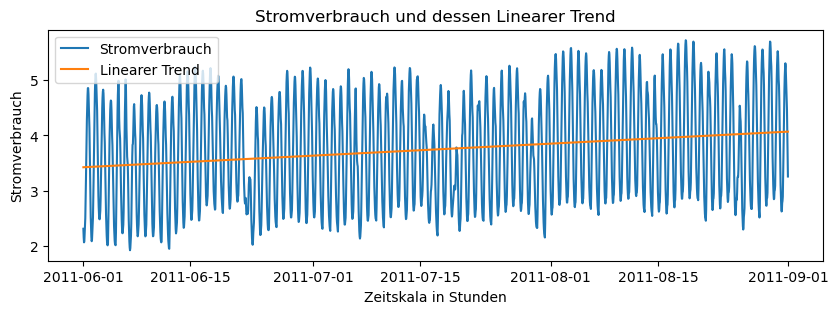

In [30]:
plotTrend(powerDF['TOTAL_LOAD'], 'Stromverbrauch', 'Stromverbrauch und dessen Linearer Trend', 'Stromverbrauch')

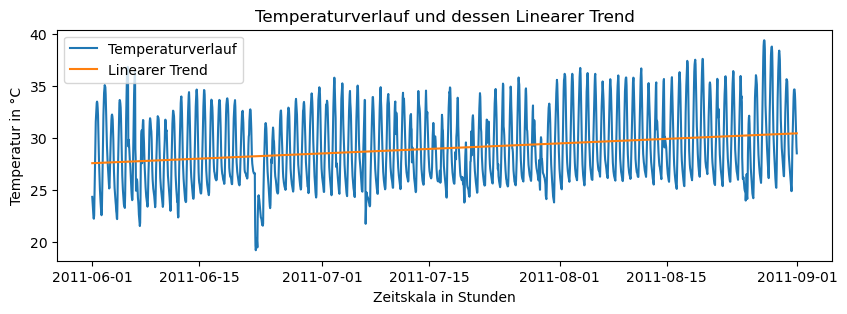

In [31]:
plotTrend(weatherDF['TEMPERATURE[C]'], 'Temperaturverlauf', 'Temperaturverlauf und dessen Linearer Trend', 'Temperatur in °C')

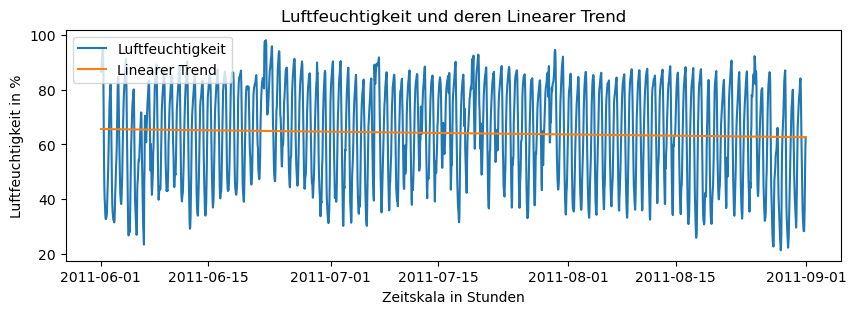

In [32]:
plotTrend(weatherDF['HUMIDITY[%]'], 'Luftfeuchtigkeit', 'Luftfeuchtigkeit und deren Linearer Trend', 'Luftfeuchtigkeit in %')

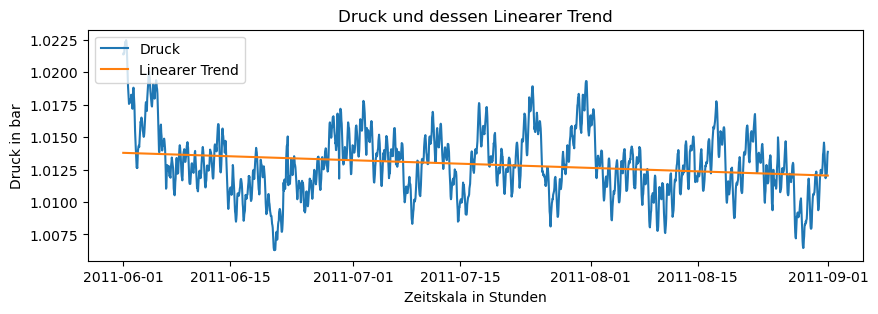

In [33]:
plotTrend(weatherDF['PRESSURE[bar]'], 'Druck', 'Druck und dessen Linearer Trend', 'Druck in bar')

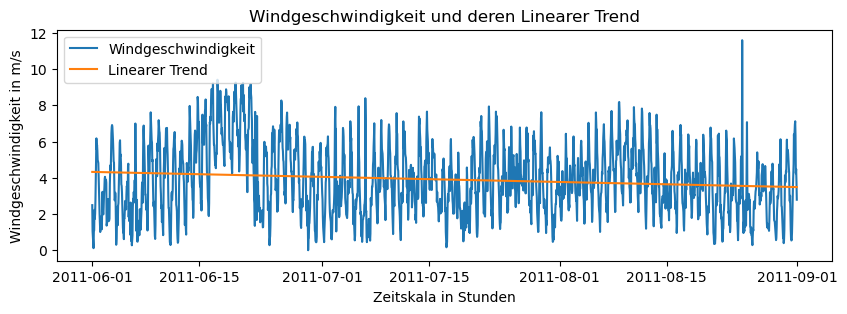

In [34]:
plotTrend(weatherDF['WIND_SPEED[m/s]'], 'Windgeschwindigkeit', 'Windgeschwindigkeit und deren Linearer Trend', 'Windgeschwindigkeit in m/s')

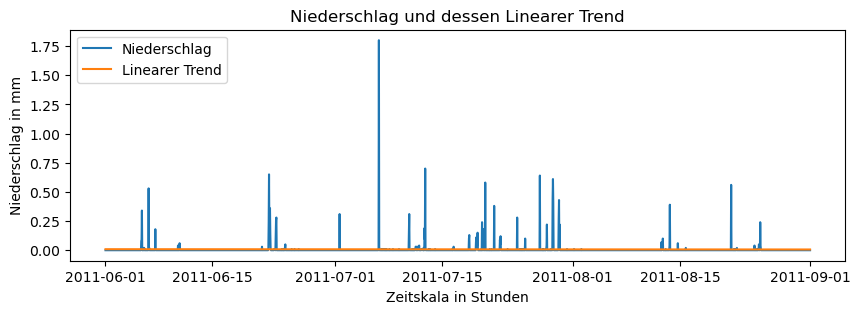

In [35]:
plotTrend(weatherDF['RAINFALL[mm]'], 'Niederschlag', 'Niederschlag und dessen Linearer Trend', 'Niederschlag in mm')

Beim Stromverbrauch ist ein leicht positiver Trend zu erkennen. Ebenso ist beim Temperaturverlauf der Trend positiv, was auch logisch ist, da die Temperatur in den 3 Sommermonaten im Durchschnitt zunimmt. Bei Luftfeuchtigkeit, Druck und Windgeschwindigkeit sind leicht negative Trends zu erkennen; beim Niederschlag gibt es keinen Trend.

## 2.2 Periodizität
Da in den vorherigen Plots bei den Datensätzen zu Stromverbrauch, Temperatur, Luftfeuchtigkeit und Windgeschwindigkeit eine sich wiederholende Struktur zu beobachten ist, werden im Folgenden die Messwerte auf Periodizität untersucht. Hierfür werden zunächst die Signale vom Trend bereinigt, wobei nur ein Zeitfenster von ein paar aufeinanderfolgenden Tagen betrachtet wird, um genauere Beobachtungen erzielen zu können. Dabei werden die einzelnen Messwerte wieder geplottet.

In [36]:
def plotDetrend(data, title, y_axis):
    plt.figure(figsize=(10, 3))

    y_LinReg = linReg(data)
    detrendData = data - y_LinReg
    plt.plot(detrendData);
    
    plt.title(title);
    plt.xlabel('Zeitskala in Stunden');
    plt.ylabel(y_axis);

    plt.show()

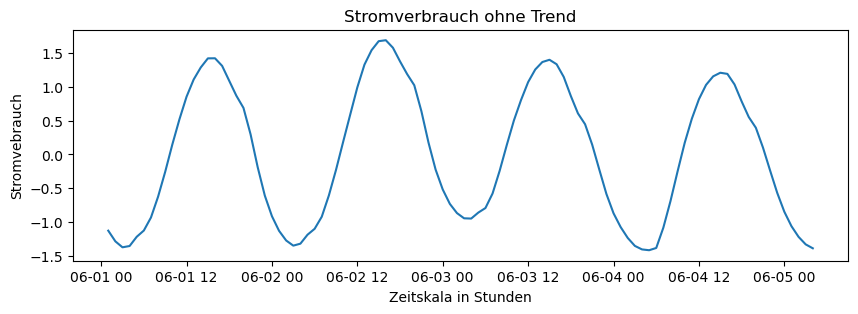

In [37]:
plotDetrend(powerDF['TOTAL_LOAD'][0:100], 'Stromverbrauch ohne Trend', 'Stromvebrauch')

Man erkennt im obigen Plot eindeutig eine Periodizität. Die Peaks haben in etwa einen zeitlichen Abstand von 24 Stunden, wobei diese sich im Bereich des frühen Nachmittags befinden. Diese Beobachtung lässt sich dadurch erklären, dass zu dieser Zeit am meisten Menschen wach sind und arbeiten/ produktiv sind und somit mit am meisten Strom verbrauchen. Nachts hingegen ist der Stromverbrauch am geringsten, da die Mehrheit der Menschen am schlafen ist und somit nicht viel Verbrauch zustande kommt. Dadurch erhält man eine Saisonalität im Sinne von Tag und Nacht, bzw. eine sich wiederholende Struktur alle 24 Stunden.

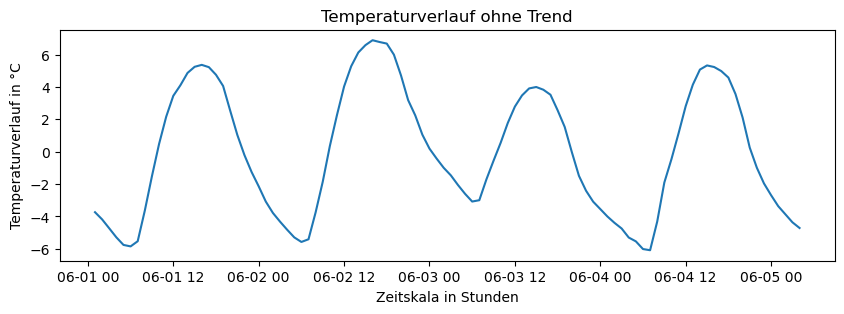

In [38]:
plotDetrend(weatherDF['TEMPERATURE[C]'][0:100], 'Temperaturverlauf ohne Trend', 'Temperaturverlauf in °C')

Auch hier ist eine periodische Struktur zu erkennen. Die Peaks haben ebenfalls einen zeitlichen Abstand von 24 Stunden und befinden sich im Bereich des frühen Nachmittags. Dies lässt sich dadurch erklären, dass die Temperatur am Nachmittag den höchsten Wert erzielt und im Laufe des Tages abnimmt, bis sie in der Nacht ihr Tief hat, da logischerweise die Sonne nicht mehr scheint.

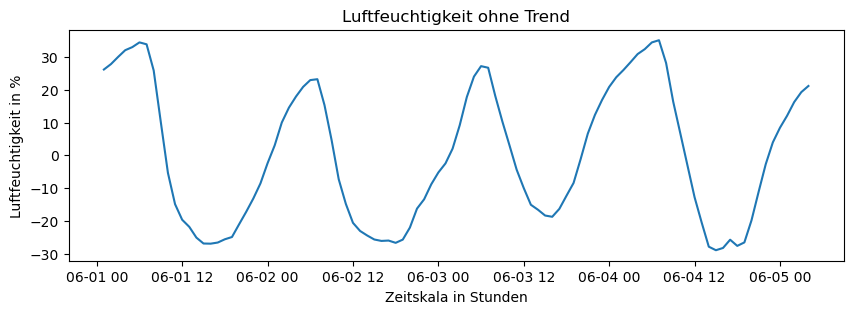

In [39]:
plotDetrend(weatherDF['HUMIDITY[%]'][0:100], 'Luftfeuchtigkeit ohne Trend', 'Luftfeuchtigkeit in %')

Bei der Luftfeuchtigkeit ist eine zum Temperaturverlauf entgegengesetzte Periodizität zu erkennen, da die Peaks genau an den Stellen der Tiefs der Temperatur liegen. Dies liegt daran, dass bei niedriger Temperatur, die vor allem nachts vorliegt, auch die Luft abkühlt. Da kalte Luft weniger Wasser halten kann als warme Luft, steigt bei gleicher absoluter Menge an Feuchtigkeit die relative Luftfeuchtigkeit.

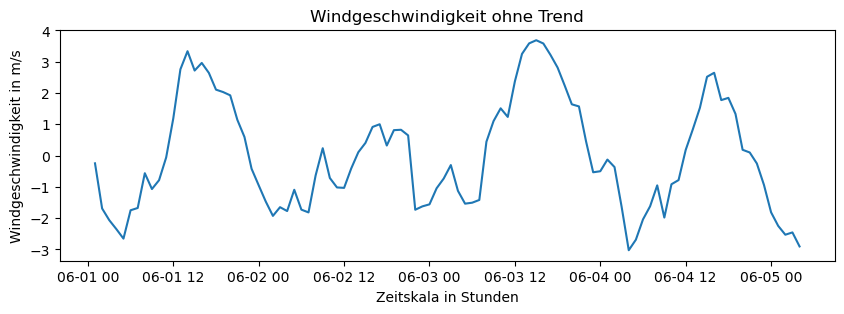

In [40]:
plotDetrend(weatherDF['WIND_SPEED[m/s]'][0:100], 'Windgeschwindigkeit ohne Trend', 'Windgeschwindigkeit in m/s')

Bei der Windgeschwindigkeit ist eine leichte periodische Struktur zu erkennen, die sich der Temperatur anpasst. Die Abstände betragen ebenfalls 24 Stunden, wobei tagsüber mehr Wind ist als nachts. Diese Beobachtung lässt sich in der Meterologie damit erklären, dass die Windgeschwindigkeit eine starke positive Korrelation mit der Temperatur hat.

Zusammenfassend lässt sich somit sagen, dass bei allen vier betrachteten Datensätzen eine Tag- und Nacht-Saisonalität vorliegt.

## 2.3 Korrelation 

In diesem Unterkapitel wird untersucht ob und welche Art von Korrelation zwischen den einzelnen Parametern besteht. Hierfür werden zunächst eine Korrelationsmatrix sowie ein Pairplot erstellt, um einen Gesamtüberblick zu erhalten.

<Axes: >

Text(0.5, 1.0, 'Korrelationsmatrix der Wetter- und Stromdaten')

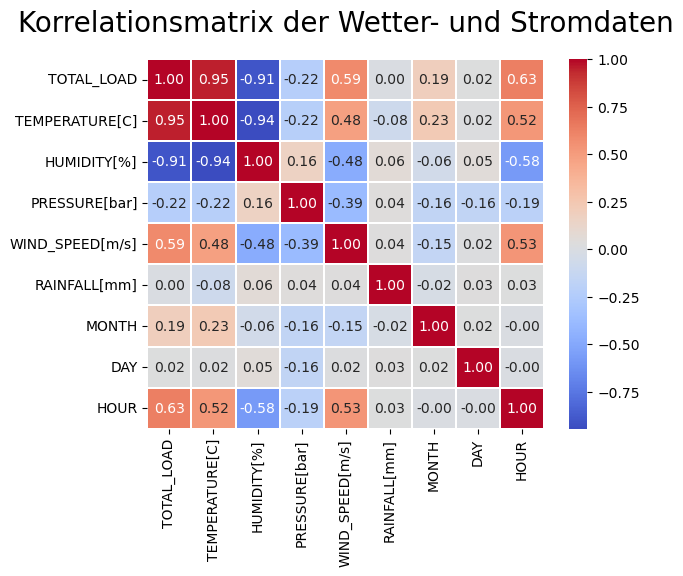

In [41]:
#generate the correlation matrix
corrMatrix = weather_powerDF.corr()

#Plot the corr Matrix
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.2)
plt.title('Korrelationsmatrix der Wetter- und Stromdaten', size=20, pad = 20)
plt.show()

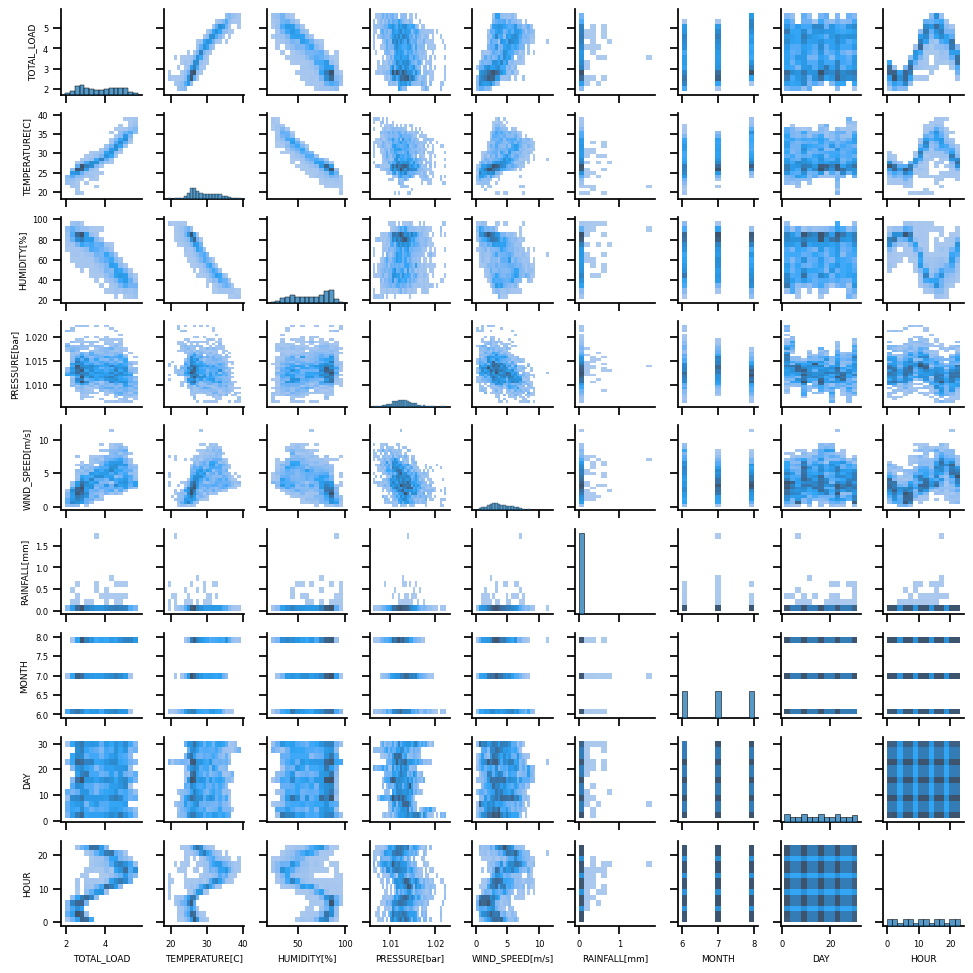

In [42]:
#Define settings for the pairplot
sns.set_context("notebook", rc={"axes.labelsize": 6.5, "xtick.labelsize": 6, "ytick.labelsize": 6})

sns.pairplot(weather_powerDF, height=1.1, kind="hist")

Aus der Korreltaionsmatrix sowie aus dem Pairplot erkennt man eine stark positive Korrealtion zwischen Temperatur und Stromverbrauch. Dies lässt sich darauf zurückführen, dass tagsüber eine höhere Temperatur vorliegt als nachts und gleichzeitig am Tag mehr Menschen wach sind, die Strom verbrauchen als nachts. Da wie bereits vorhin beobachtet zwischen Temperatur und Luftfeuchtigkeit eine negative Korrelation besteht, sind die Parameter Luftfeuchtigkeit und Stromverbrauch ebenfalls negativ korrelativ zueinander.

  Die Windgeschwindigkeit hat eine leichte positive Korrelation mit dem Stromverbrauch, was ebenfalls mit der Abhängigkeit von der Temperatur zu erklären ist.

p Value etc. 

## 2.4 Ausreißer 

#Funktion schreiben die diese detektiert
22.06.2011 
https://www.spiegel.de/panorama/regen-hagel-sturm-tausende-haushalte-nach-unwetter-ohne-strom-a-769966.html 

19.07.2011 ??? 

<Axes: xlabel='#DATE'>

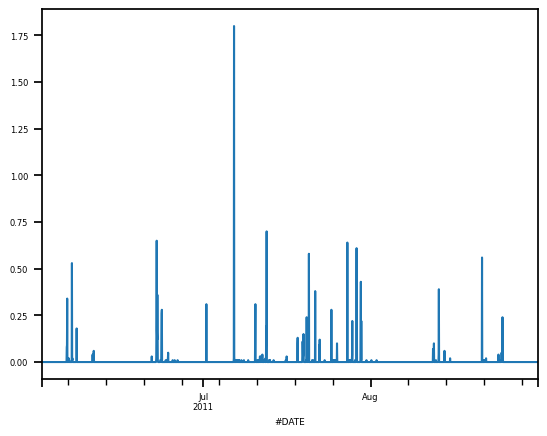

In [43]:
weatherDF['RAINFALL[mm]'].plot()

# 3. Vorbereitung für die Porgnosemodelle
Nun widmen wir uns der Aufgabenstellung den Stromverbrauch für 1h bzw. 24h nach vorne vorherzusagen. Dazu sollen verschiedene Modelle zur Prognose der Daten ausprobiert und miteinander verglichen werden.  

Zunächst müssen wir den zu Datetime gesetzten Index in unserem weather_powerDF Datensatz zurücksetzen, um eine Kompatibilität der Datenstruktur mit den zukünftig angewandten Modellen zu gewährleisten. DAbei wird der Ursprüngliche INdex als Spalte dem DataFrame hinzugefüht, was uns allerdings nicht weiter stört, da die Features und Targets separat definiert sind.

## 3.1 Anpassung der Targets
Jetzt passen wir die Datensätze so an, dass wir die Werte der Stromverbrauchs um 1h bzw 24H nach vorne ziehen und somit eine entsprechende versetzte Zurodnung zu den Wetterdaten erzeugen.  
So wird gewährleistet, dass die Modelle zu den aktuellen Wetterdaten die zukünftigen Stromverbrauchsdaten als Referenz besitzen und darauf traniert werden Prognosen zu erstellen und nicht nur den aktuellen Verbrauch einzuschätzen.

In [44]:
#Add new columns to the targets list
targets += ['TOTAL_LOAD_1H', 'TOTAL_LOAD_24H']

#Add target to the general df
weather_powerDF[targets[0]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-1))
weather_powerDF[targets[1]] = pd.DataFrame(weather_powerDF.loc[:, 'TOTAL_LOAD'].shift(-24))

## 3.2 Train-Test Split
Da unser Datensatz nur drei Monate eines Jahres beinhaltet, benutzen wir einfachheitshalber die ersten 80% der Daten als unsere Trainingsdaten und die restlichen 20% als Testdaten.  

In [45]:
#Position of the row next to 80% of the data
index80percent = round(len(weather_powerDF)*0.8)

weather_powerDF_train = weather_powerDF[:index80percent]
weather_powerDF_test = weather_powerDF[index80percent:]

Wir wollen unserern Datensatz in Trainingsdaten und Testdaten unterteilen. Dazu wählen wir je die Feature und Target Spalten.

In [46]:
#Train and Test Dataset for the Features
X_train = weather_powerDF_train[features]
X_test = weather_powerDF_test[features]

#Train and Test Dataset for the Targets 1H and 24H ahead
y_1H_train = weather_powerDF_train[targets[0]]
y_1H_test = weather_powerDF_test[targets[0]]
y_24H_train = weather_powerDF_train[targets[1]]
y_24H_test = weather_powerDF_test[targets[1]]

## 3.3 Funktionen für Modelanalyse und Vergleich 
Um später das Prognosemodell bewerten zu können und auch die verschiedenen Modelle effetkiv miteinander vergleichen zu können ist es sinnvoll stets dafür geeignete Metriken und Grafiken zu generieren.  
Dazu definieren wir Funtkionen, um diesen Prozess zu vereinheitlichen und Duplikate zu vermeiden.  
Auch für häufig verwendete Abläufe wollen wir Funktionen definieren.

### 3.3.1 Allgemeine Funktionen 
In allen Modellen wollen wir die Vorhersagen mit den tatsächlichen Werten vergleichen.  
Dazu wollen wir die Daten in einem DF bündeln und optional einen Titel übergeben, der den DF beschreibt.

In [47]:
def createPredObservDF(actual_data, pred_data, title):
    df = pd.DataFrame({'Observations': actual_data, 'Predictions': pred_data})

    #Access to the df title with df.attrs['title']
    df.attrs['title'] = title

    return df

### 3.3.2 Funktionen für die Modelanalyse
Auch die Bewertung der Modelle ist stets relevant. Dazu werden verschiedene Metriken verwendet, die diesen Prozess greifbarer machen.  
Wir haben uns auf die Folgenden festgelegt:

* Mean Absolute Error (mae) - Misst den durchschnittlich absoluten Unterschied zwischen den vorhergesagten und den tatsächlichen Werten.  
Diese Metrik gibt einen intuitiven Eindruck von der Größe der Fehler.

* Mean Squared Error (mse) - Misst den durchschnittlich quadrierten Fehler. Diese Metrik betont größere Fehler stärker, da Fehler quadriert werden.

* Root Mean Squared Error (rmse) - Der quadratische Mittelwert-Fehler ist die Quadratwurzel des mittleren quadratischen Fehlers. RMSE bringt die Metrik zurück in die ursprünglichen Einheiten und gibt eine Vorstellung von der Größe der Fehler. Es ist besonders nützlich, wenn größere Fehler problematischer sind.

* Korrelation - Misst die Stärke und Richtung der linearen Beziehung zwischen den vorhergesagten und den tatsächlichen Werten.

* Bias - Der Bias misst die systematische Abweichung der Vorhersagen von den tatsächlichen Werten. Ein hoher Bias kann darauf hinweisen, dass das Modell konsistent zu hohe oder zu niedrige Vorhersagen macht.

Diese können bei Übergabe der Ergebnisse erstellt werden. 

In [48]:
def modelMetrics(train_results, test_results):
    #generate DF to store the metrics
    metricDF = pd.DataFrame(columns = ['Train Data', 'Test Data'], index = ['msa', 'mse', 'rmse', 'corr', 'bias'])

    for column, df in zip(metricDF.columns, [train_results, test_results]):
        #Drop possible NaN values from df (Could occur when future data is predicted without actual target data)
        df = df.dropna()

        #Compute relevant metrics for model analysis and comparision
        msa = mean_absolute_error(df.iloc[:, 0], df.iloc[:, 1])
        mse = mean_squared_error(df.iloc[:, 0], df.iloc[:, 1])
        rmse = np.sqrt(mse)
        corr = np.corrcoef(df.iloc[:, 0], df.iloc[:, 1])[0,1]
        bias = np.mean(df.iloc[:, 1])-np.mean(df.iloc[:, 0])

        #Add metrics to the DF in the corresponding column
        metricDF.loc[:, column] = [msa, mse, rmse, corr, bias]

    return metricDF.T

### 3.3.3 Funktionen für Grafiken
Eine Visualiserug der Ergebnisse ist eine gut Möglichkeit, um schnell sich einen Eindruck verschaffen uz können, ohne genaue Zahlenwerte untersuchen zu müssen.  
  
Dazu erstellen wir zunächst einen Plot der für die Trainings- und Testdaten die tatsächlichen und vorhergesagten Werte gegenüberstellt.

In [49]:
def plot_results(train_results, test_results, title):
    #Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    #plot train and test separate in subplots
    for ax, df in zip((ax1, ax2), (train_results, test_results)):
        #Plot the data
        ax.plot(df['Predictions'], label='Predicted')
        ax.plot(df['Observations'], label='Observations')

        #Highlight Predictions in ax2 where Observations are missing
        if df['Observations'].isna().any():
            missing_indices = df.index[df['Observations'].isna()]
            ax.plot(df.loc[missing_indices, 'Predictions'], label='Predicted (No Observations)', color='tab:red', linewidth=2, marker ='o')

            handles, labels = ax2.get_legend_handles_labels()
            ax2.legend(handles=handles, labels=labels, loc='upper right')

        #Adjust the subplots
        ax.set_title(df.attrs.get('title'))
        ax.set_xlabel('Zeitskala')
        ax.set_ylabel('Stromverbrauch')
        ax.legend(loc='upper left')
        ax.grid(True)

    #Adjust the general plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(title)

    plt.show()

# 4. Multivariiates Lineares Modell 
Nun widmen wir uns der Aufgabenstellung den Stromverbrauch für je 1h oder 24h nach vorne vorherzusagen.  
Dazu soll ein Multivairates Lineares Modell erstellt werden.  
  
Im ersten Schritt müssen wir noch eine zusätzliche Spalte dem X-Datensatz hinzufügen, um die Konstante b_0 im Model zu simulieren.

In [50]:
#Add a 1-column to the model (for constant b_0 in model)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test, has_constant='add')

In [51]:
def run_MVModel(X_train, y_train, X_test, y_test):
    #Initialize and Fit the OLS model
    MV_model = sm.OLS(y_train, X_train)
    MV_model_fit = MV_model.fit()

    #Print the model summary
    print(MV_model_fit.summary())

    #Predict y values
    y_train_pred = MV_model_fit.predict(X_train)
    y_test_pred = MV_model_fit.predict(X_test)

    #Create dataframes with actual and predicted values
    train_results =  createPredObservDF(y_train, y_train_pred, 'Train Data')
    test_results = createPredObservDF(y_test, y_test_pred, 'Test Data')
    
    return train_results, test_results

                            OLS Regression Results                            
Dep. Variable:          TOTAL_LOAD_1H   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     5710.
Date:                Thu, 20 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:14:20   Log-Likelihood:                 598.83
No. Observations:                1766   AIC:                            -1178.
Df Residuals:                    1756   BIC:                            -1123.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -17.9120      1.977     

,msa,mse,rmse,corr,bias
Train Data,0.139094,0.029716,0.172385,0.983342,0.0
Test Data,0.163059,0.044153,0.210125,0.980907,-0.073474


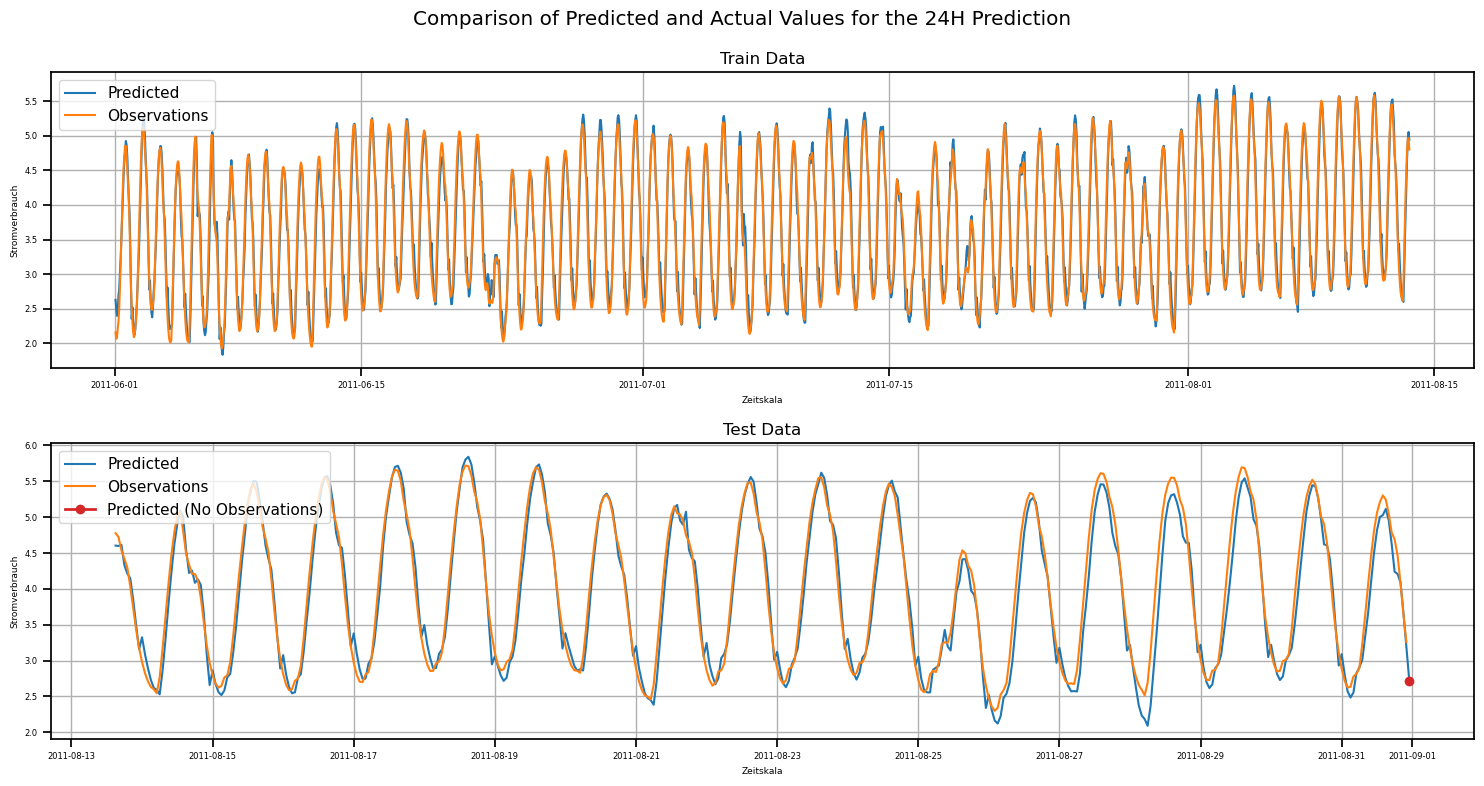

In [52]:
train_results, test_results = run_MVModel(X_train, y_1H_train, X_test, y_1H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction')

                            OLS Regression Results                            
Dep. Variable:         TOTAL_LOAD_24H   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     1678.
Date:                Thu, 20 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:14:23   Log-Likelihood:                -411.24
No. Observations:                1766   AIC:                             842.5
Df Residuals:                    1756   BIC:                             897.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -10.0807      3.502     

,msa,mse,rmse,corr,bias
Train Data,0.202766,0.093281,0.305419,0.946497,-0.0
Test Data,0.214515,0.094664,0.307675,0.956767,0.077152


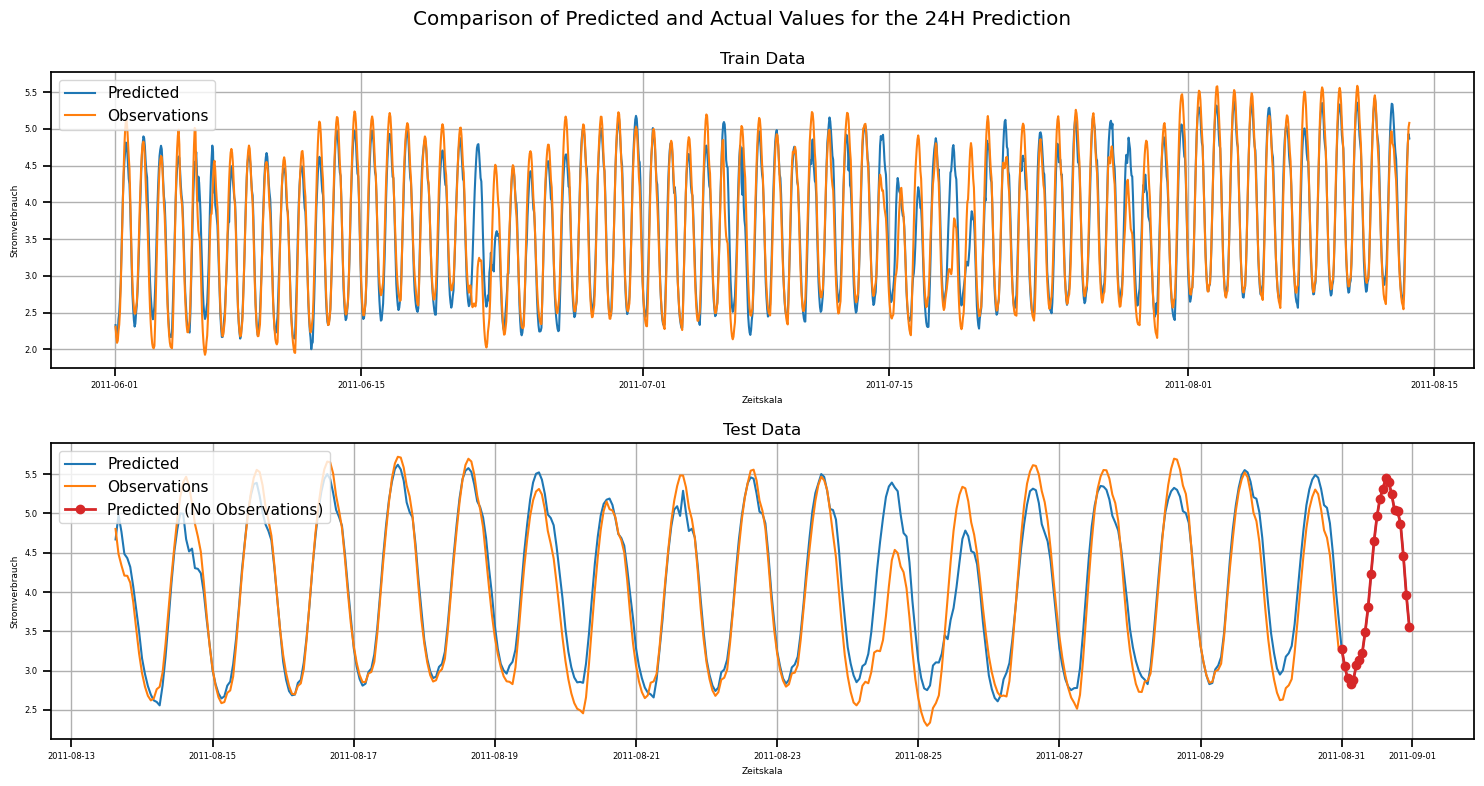

In [53]:
train_results, test_results = run_MVModel(X_train, y_24H_train, X_test, y_24H_test)
modelMetrics(train_results, test_results)
plot_results(train_results, test_results, 'Comparison of Predicted and Actual Values for the 24H Prediction')


Lag Features: Include lagged power consumption values as features (e.g., power consumption at t-1, t-2, etc.).
Rolling Statistics: Include rolling mean, rolling standard deviation, etc., of power consumption over a window of past values.
Weather Features: Include current and lagged weather data.